# Medical MNIST Dataset 
<br></br>
#### In this code today, I intend to build a good multi-class classifier which can classify 6 different human organs and predict with a decent accuracy. 
<br></br>
The code has been completely implemented in tensorflow and will serve as a beginner's guide to Deep Learning implementation. In today's code, we would be focussing on CNN.
<br></br>
[Link to the dataset used](https://www.kaggle.com/datasets/andrewmvd/medical-mnist)

In [ ]:
import os
from glob import glob
import pandas as pd
import numpy as np
from numpy import expand_dims
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sn
from skimage.transform import resize
from skimage.color import gray2rgb
from sklearn.metrics import classification_report, confusion_matrix
from IPython.display import SVG
import keract
from tensorflow import keras
from tensorflow.keras import applications, optimizers
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.utils import to_categorical, model_to_dot, plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau
from keras import layers
from keras.layers import Conv2D, Activation, add
import tensorflow as tf

#### The code below has the path of the source folder. The original dataset has 6 folders with images pertaining to those 6 classes but no training and testing split of the data. So here we perform a 80-20 training-testing split of the data.

In [13]:
source_folder = "/Users/sriyans_ketavarapu/Desktop/ML_Datasets/medical_mnist"

# Set the destination folders for training and testing data
training_folder = "/Users/sriyans_ketavarapu/Desktop/ML_Datasets/training"
testing_folder = "/Users/sriyans_ketavarapu/Desktop/ML_Datasets/testing"
# Set the percentage for the training split (e.g., 80%)
training_percentage = 80

# Create destination folders
os.makedirs(training_folder, exist_ok=True)
os.makedirs(testing_folder, exist_ok=True)

# Iterate through each class folder
for class_folder in os.listdir(source_folder):
    class_folder_path = os.path.join(source_folder, class_folder)

    # Create corresponding destination folders for this class in training and testing
    training_class_folder = os.path.join(training_folder, class_folder)
    testing_class_folder = os.path.join(testing_folder, class_folder)

    os.makedirs(training_class_folder, exist_ok=True)
    os.makedirs(testing_class_folder, exist_ok=True)

    # List all image files in the class folder
    image_files = [f for f in os.listdir(class_folder_path) if f.endswith(".jpeg")]  # Update the file extension as needed

    # Shuffle the image list randomly
    random.seed(42)  # Set a seed for reproducibility
    random.shuffle(image_files)

    # Calculate the number of images for training and testing
    num_images = len(image_files)
    num_training_images = int(num_images * (training_percentage / 100))
    num_testing_images = num_images - num_training_images

    # Split the images into training and testing sets
    training_images = image_files[:num_training_images]
    testing_images = image_files[num_training_images:]

    # Copy training images to the training class folder
    for image in training_images:
        source_image_path = os.path.join(class_folder_path, image)
        destination_image_path = os.path.join(training_class_folder, image)
        shutil.copy(source_image_path, destination_image_path)

    # Copy testing images to the testing class folder
    for image in testing_images:
        source_image_path = os.path.join(class_folder_path, image)
        destination_image_path = os.path.join(testing_class_folder, image)
        shutil.copy(source_image_path, destination_image_path)

print("Data splitting complete.")


Data splitting complete.


#### Here, we generate the train, test and validation batches.
<br></br>
**The training batches are used to train the model**
<br></br>
**The validation batches are used to fine tune the model during the training phase**
<br></br>
**The test batches are used to analyse the performance of the final model**

In [16]:
train_path = r'/Users/sriyans_ketavarapu/Desktop/ML_Datasets/medical_mnist/training/'
test_path = r'/Users/sriyans_ketavarapu/Desktop/ML_Datasets/medical_mnist/testing/'
train_batches = ImageDataGenerator(validation_split=0.1) \
                .flow_from_directory(directory=train_path,  
                                     classes = ['AbdomenCT', 'BreastMRI', 
                                                'ChestCT', 'CXR','Hand','HeadCT'], 
                                     subset='training',
                                     batch_size=10)

validation_batches = ImageDataGenerator(validation_split=0.1) \
                     .flow_from_directory(directory=train_path, 
                                          classes = ['AbdomenCT', 'BreastMRI', 
                                                'ChestCT', 'CXR','Hand','HeadCT'], 
                                          subset='validation',
                                          batch_size=10)
                
test_batches = ImageDataGenerator() \
                    .flow_from_directory(directory=test_path, 
                                        classes = ['AbdomenCT', 'BreastMRI', 
                                                'ChestCT', 'CXR','Hand','HeadCT'], 
                                         batch_size=10, 
                                         shuffle=False)


Found 42447 images belonging to 6 classes.
Found 4716 images belonging to 6 classes.
Found 11791 images belonging to 6 classes.


<BarContainer object of 6 artists>

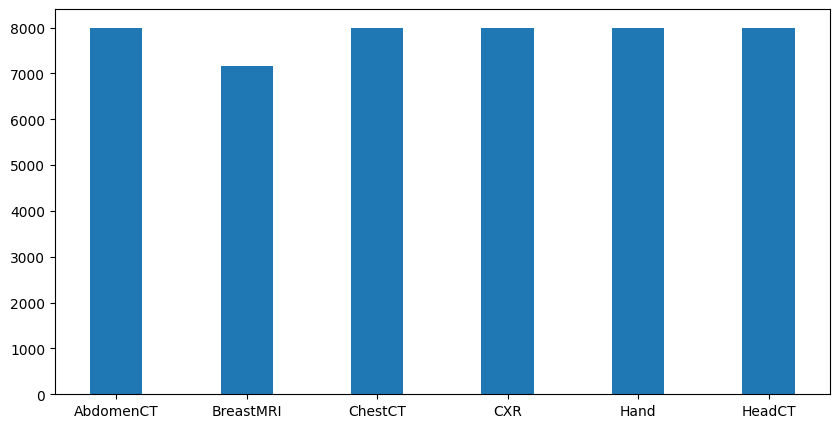

In [18]:
data = {'AbdomenCT':      0, 
        'BreastMRI': 0, 
        'ChestCT':     0,
        'CXR': 0,
        'Hand':0,
        'HeadCT':0}

for cls in os.listdir(train_path):
    for img in os.listdir(train_path + '/' + cls):
        data[cls] = data[cls] + 1

keys = list(data.keys())
values = list(data.values())
  
fig = plt.figure(figsize = (10, 5))
 
plt.bar(keys, values, width = 0.4)

#### Printing samples from each class just to show how the data looks like 

AbdomenCT


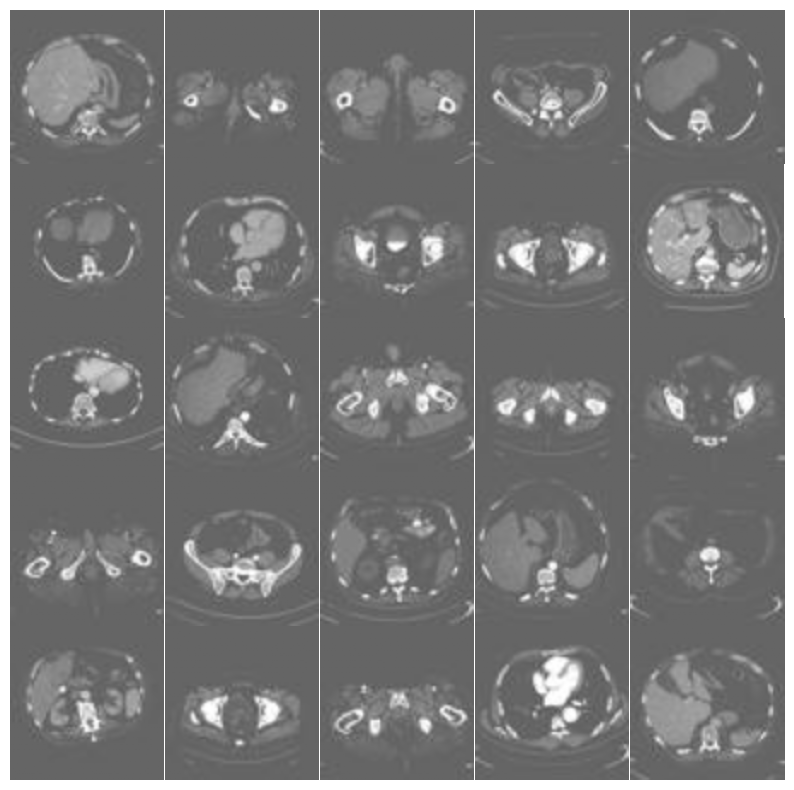

In [27]:
print("AbdomenCT")
data_dir = '/Users/sriyans_ketavarapu/Desktop/ML_Datasets/medical_mnist/'
multipleImages = glob(data_dir + 'training/AbdomenCT/**')
i = 0
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)
for im in multipleImages[:25]:
    image = mpimg.imread(im)
    image_resized = resize(image, (128, 128)) 
    plt.subplot(5, 5, i+1) #.set_title(l)
    plt.imshow(gray2rgb(image_resized)); plt.axis('off')
    i += 1
plt.savefig('abdomen.png', transparent= False, bbox_inches= 'tight', dpi= 400)

BreastMRI


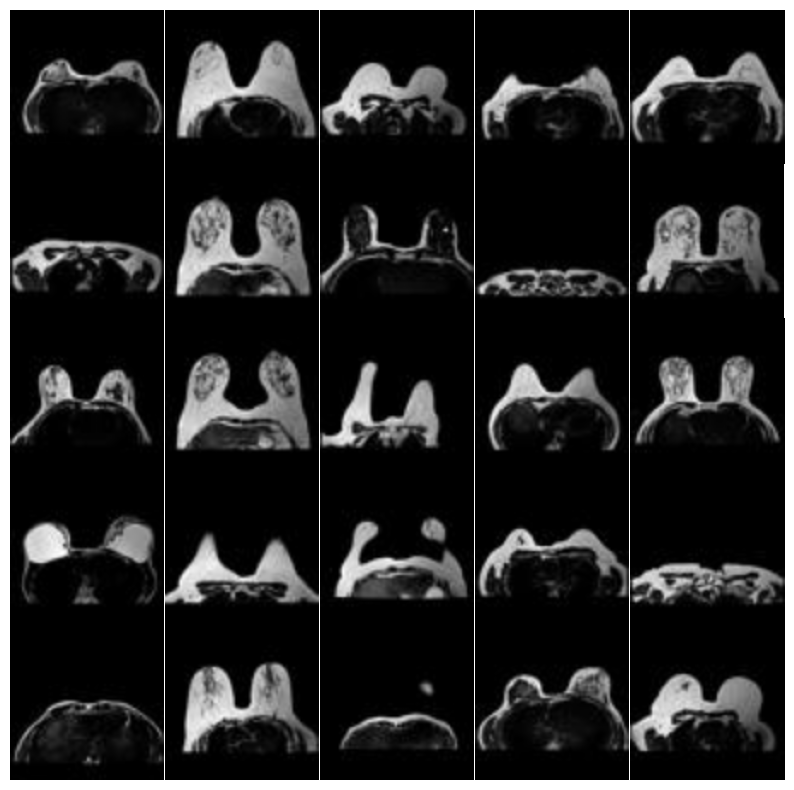

In [28]:
print("BreastMRI")
multipleImages = glob(data_dir + 'training/BreastMRI/**')
i = 0
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)
for im in multipleImages[:25]:
    image = mpimg.imread(im)
    image_resized = resize(image, (128, 128)) 
    plt.subplot(5, 5, i+1) #.set_title(l)
    plt.imshow(gray2rgb(image_resized)); plt.axis('off')
    i += 1
plt.savefig('breast.png', transparent= False, bbox_inches= 'tight', dpi= 400)

ChestCT


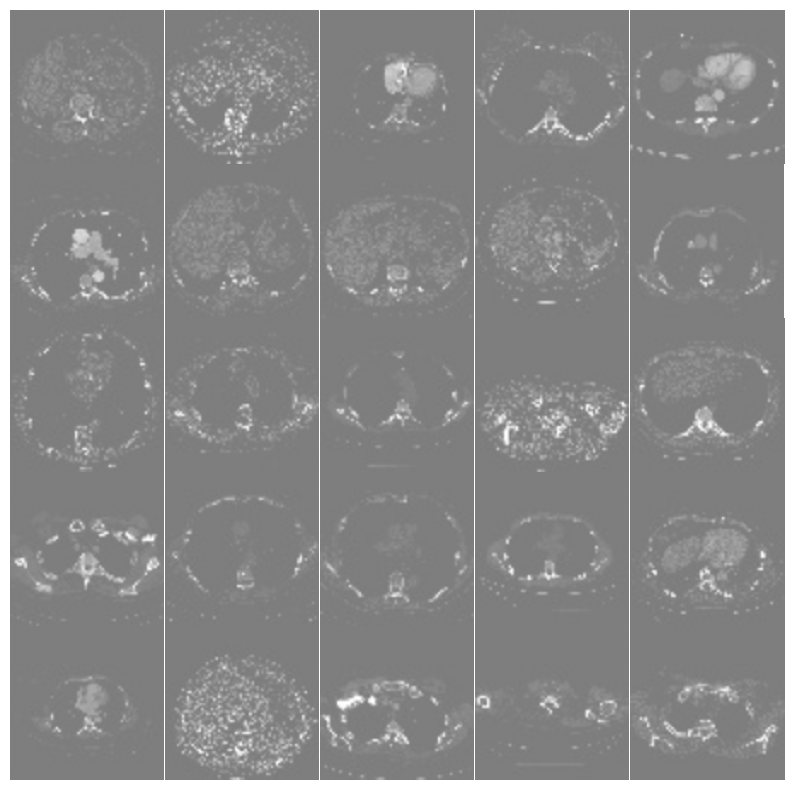

In [29]:
print("ChestCT")
multipleImages = glob(data_dir + 'training/ChestCT/**')
i = 0
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)
for im in multipleImages[:25]:
    image = mpimg.imread(im)
    image_resized = resize(image, (128, 128)) 
    plt.subplot(5, 5, i+1) #.set_title(l)
    plt.imshow(gray2rgb(image_resized)); plt.axis('off')
    i += 1
plt.savefig('chest.png', transparent= False, bbox_inches= 'tight', dpi= 400)

Hand


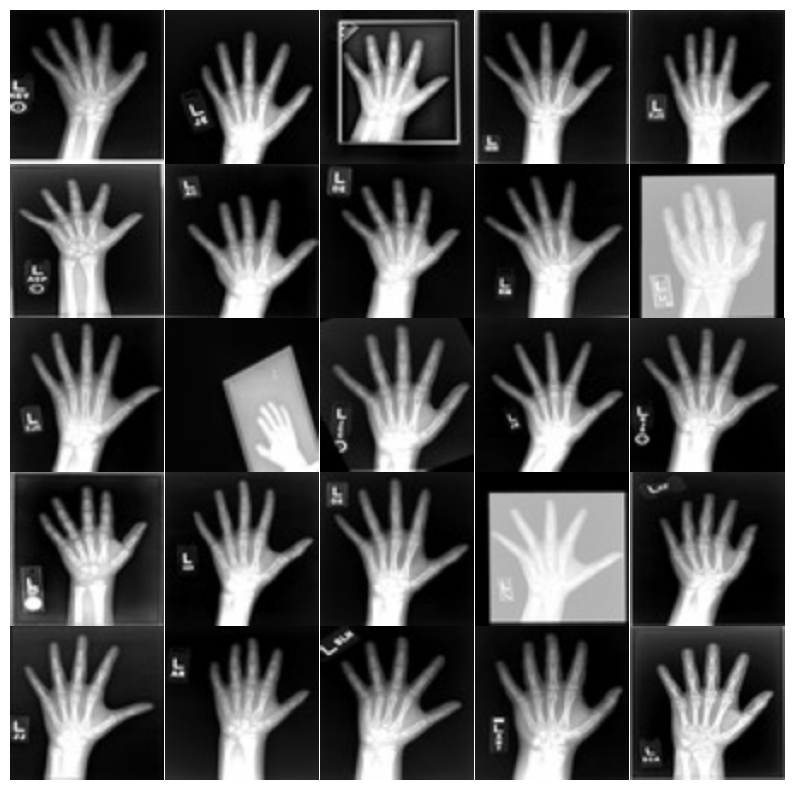

In [30]:
print("Hand")
multipleImages = glob(data_dir + 'training/Hand/**')
i = 0
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)
for im in multipleImages[:25]:
    image = mpimg.imread(im)
    image_resized = resize(image, (128, 128)) 
    plt.subplot(5, 5, i+1) #.set_title(l)
    plt.imshow(gray2rgb(image_resized)); plt.axis('off')
    i += 1
plt.savefig('hand.png', transparent= False, bbox_inches= 'tight', dpi= 400)

HeadCT


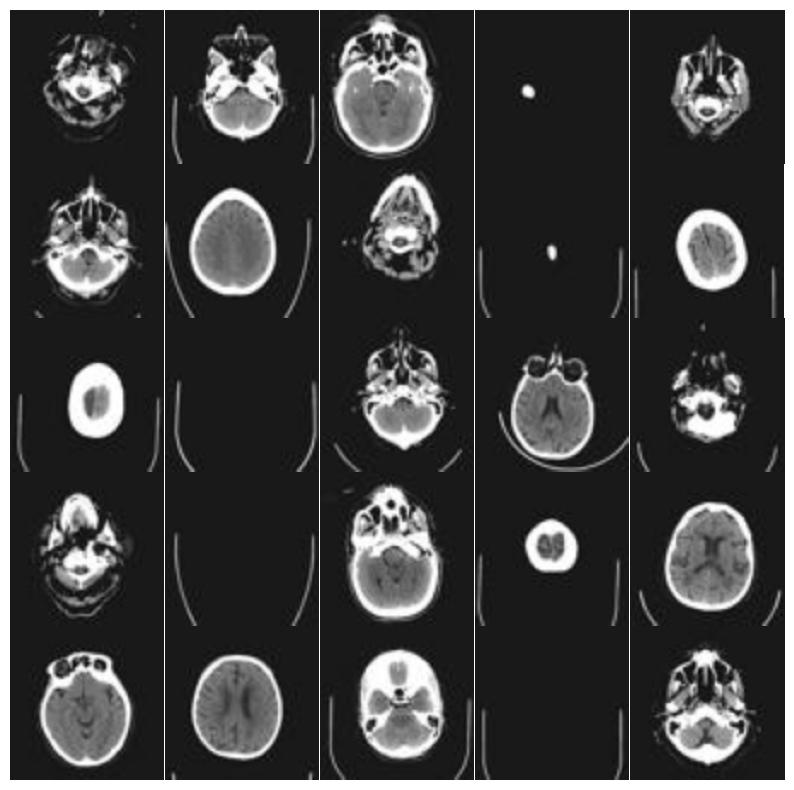

In [31]:
print("HeadCT")
multipleImages = glob(data_dir + 'training/HeadCT/**')
i = 0
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)
for im in multipleImages[:25]:
    image = mpimg.imread(im)
    image_resized = resize(image, (128, 128)) 
    plt.subplot(5, 5, i+1) #.set_title(l)
    plt.imshow(gray2rgb(image_resized)); plt.axis('off')
    i += 1
plt.savefig('head.png', transparent= False, bbox_inches= 'tight', dpi= 400)

#### The following code is the definiton of the DL model 
<br></br>
**The model starts off with the input,resizing and the rescaling layers**
<br></br>
**The rescaling layer basically converts the pixel values from the range of [0,255] to [0,1]**
<br></br>
**The image size I have taken is (128,128,3), taking (224,224,3) gives a better result in the same number of EPOCHS**


In [80]:
IMG_SIZE = 128
n_classes = 6

inp = layers.Input(shape=(IMG_SIZE,IMG_SIZE,3))
x1 = layers.Resizing(IMG_SIZE, IMG_SIZE)(inp)
x2 = layers.Rescaling(1./255)(x1)
x3 = layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', 
                   padding = 'same', input_shape=(IMG_SIZE,IMG_SIZE,3))(x2)
x5 = layers.BatchNormalization(axis=-1)(x3)
x6 = layers.MaxPool2D(pool_size=(2, 2))(x5)
x7 = layers.Conv2D(filters=64, kernel_size=(3, 3), 
                   activation='relu', padding = 'same')(x6)
x9 = layers.BatchNormalization(axis=-1)(x7)
x10 = layers.MaxPool2D(pool_size=(2, 2))(x9)

x11 = layers.Conv2D(filters=128, kernel_size=(3, 3), 
                    activation='relu', padding = 'same')(x10)
x13 = layers.BatchNormalization(axis=-1)(x11)
x14 = layers.MaxPool2D(pool_size=(2, 2))(x13)
x15 = layers.Conv2D(filters=256, kernel_size=(3, 3), 
                      activation='relu', padding = 'same')(x14)
x17 = layers.BatchNormalization(axis=-1)(x15)
x18 = layers.MaxPool2D(pool_size=(2, 2))(x17)
y1 = layers.Flatten()(x18)
y2 = layers.Dense(300, activation='relu')(y1)
y3 = layers.Dense(150, activation='relu')(y2)
y4 = layers.Dropout(0.25)(y3)
y = layers.Dense(n_classes, activation='softmax')(y4)   

model = keras.Model(inp,y)

#### Below is the summary of the model, incase of any errors while fitting, the summary is what helps us best to understand the error

In [81]:
EPOCHS = 5
BATCH_SIZE = 8
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
                  loss='categorical_crossentropy', 
                  metrics='accuracy')
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 resizing_2 (Resizing)       (None, 128, 128, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 128, 128, 32)      896       
                                                                 
 batch_normalization_8 (Bat  (None, 128, 128, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 64, 64, 32)        0         
 g2D)                                                      

In [82]:
history = model.fit(x=train_batches,
                            validation_data=validation_batches,
                            steps_per_epoch=len(train_batches),
                            validation_steps=len(validation_batches),
                            epochs=EPOCHS,
                            batch_size=BATCH_SIZE, 
                            verbose=1)

Epoch 1/5
4245/4245 [==============================] - 500s 117ms/step - loss: 0.1232 - accuracy: 0.9879 - val_loss: 0.0331 - val_accuracy: 0.9983
Epoch 2/5
4245/4245 [==============================] - 494s 116ms/step - loss: 0.0968 - accuracy: 0.9956 - val_loss: 0.1541 - val_accuracy: 0.9945
Epoch 3/5
4245/4245 [==============================] - 483s 114ms/step - loss: 0.0885 - accuracy: 0.9975 - val_loss: 0.0427 - val_accuracy: 0.9994
Epoch 4/5
4245/4245 [==============================] - 469s 110ms/step - loss: 0.0666 - accuracy: 0.9984 - val_loss: 0.0745 - val_accuracy: 0.9983
Epoch 5/5
4245/4245 [==============================] - 471s 111ms/step - loss: 0.0561 - accuracy: 0.9986 - val_loss: 0.8297 - val_accuracy: 0.9671


#### Below we just print a graph and the confusion matrix. The matrix will be many times better if the input shape were (224,224,3). You can check that for yourself.

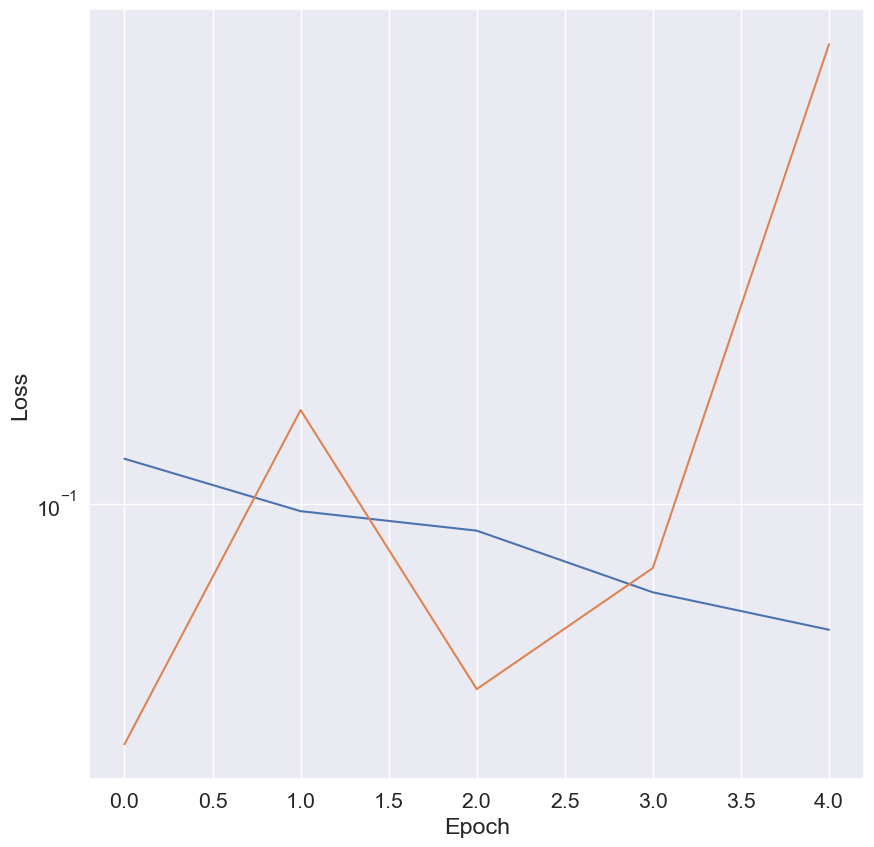

In [83]:
def plot_loss(history, n):
    plt.semilogy(history.epoch, history.history['loss'], label='Train')
    plt.semilogy(history.epoch, history.history['val_loss'], label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
plot_loss(history, 0)

In [84]:
loss_and_metrics = model.evaluate(test_batches, batch_size=BATCH_SIZE, verbose=1)

1180/1180 [==============================] - 93s 79ms/step - loss: 0.4110 - accuracy: 0.9841


1180/1180 [==============================] - 58s 49ms/step


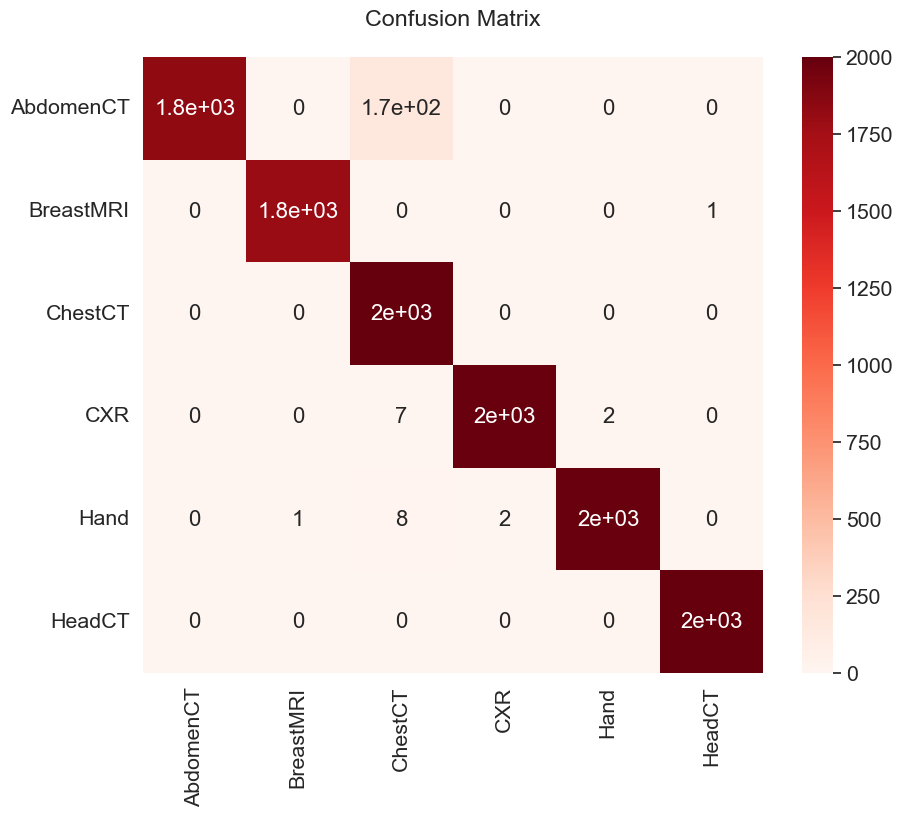

Classification Report

              precision    recall  f1-score   support

   AbdomenCT       1.00      0.92      0.96      2000
   BreastMRI       1.00      1.00      1.00      1791
     ChestCT       0.92      1.00      0.96      2000
         CXR       1.00      1.00      1.00      2000
        Hand       1.00      0.99      1.00      2000
      HeadCT       1.00      1.00      1.00      2000

    accuracy                           0.98     11791
   macro avg       0.99      0.98      0.98     11791
weighted avg       0.99      0.98      0.98     11791



In [86]:
num_classes = len(train_batches.class_indices)  
train_labels = train_batches.classes 
train_labels = to_categorical(train_labels, num_classes=num_classes)
valid_labels = validation_batches.classes 
valid_labels = to_categorical(valid_labels, num_classes=num_classes)
nb_train_samples = len(train_batches.filenames)  
nb_valid_samples = len(validation_batches.filenames)
nb_test_samples = len(test_batches.filenames)
Y_pred = model.predict(test_batches, nb_test_samples // BATCH_SIZE+1)
y_pred = np.argmax(Y_pred, axis=1)
cm = confusion_matrix(test_batches.classes, y_pred)
df_cm = pd.DataFrame(cm, list(test_batches.class_indices.keys()), list(test_batches.class_indices.keys()))
fig, ax = plt.subplots(figsize=(10,8))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, cmap=plt.cm.Reds)
plt.title('Confusion Matrix\n')
plt.savefig('confusion_matrix.png', transparent= False, bbox_inches= 'tight', dpi= 400)
plt.show()

print('Classification Report\n')
target_names = list(test_batches.class_indices.keys())
print(classification_report(test_batches.classes, y_pred, target_names=target_names))